# Multiprocessing using Pools 
A simple framework for assessing the impact of multiprocessing on runtime on a multi-core machine. 

In [28]:
import time
import math
import multiprocessing
from multiprocessing import Pool
import matplotlib.pyplot as plt

# A function for timing a job that uses a pool of processes.
#  f is a function that takes a single argument
#  data is an array of arguments on which f will be mapped
#  pool_size is the number of processes in the pool. 
def pool_process(f, data, pool_size):
    tp1 = time.time()
    pool = Pool(processes=pool_size) # initialize the Pool.
    result = pool.map(f, data)       # map f to the data using the Pool of processes to do the work 
    pool.close() # No more processes
    pool.join()  # Wait for the pool processing to complete. 
    
    return int(time.time()-tp1)
 

## Load Target function separately 
The target function needs to be loaded in from a separate python file.
So save this function declaration in a file miscFunc.py

    import math

    def my_func(x):  
        s = math.sqrt(x)  
        return s
    

In [12]:
import miscFunc as miscFunc # if miscFunc.py is changed the kernel needs to be restarted. 

This verbose version shows which process in the pool is running each task.   
Put this definition in miscFunc.py as well.  

    def my_func_verbose(x):
        s = math.sqrt(x)
        print("Task", multiprocessing.current_process(), x, s)
        return s

In [13]:
dataRange = range(20)

Use the pool_process function to apply my_func to the data in dataRange.  
This task is so light it requires very little processing time. 

In [14]:
dataRange = range(10)
pool_process(miscFunc.my_func, dataRange, 1)

0

## A naive function for checking primes 

In [15]:
check_work = [45,13,4]

In [16]:
pool_process(miscFunc.my_func_verbose, check_work, 1)

Task <ForkProcess(ForkPoolWorker-16, started daemon)> 45 6.708203932499369
Task <ForkProcess(ForkPoolWorker-16, started daemon)> 13 3.605551275463989
Task <ForkProcess(ForkPoolWorker-16, started daemon)> 4 2.0


0

In [17]:
prime_data =[]
file = open("primes.txt","r")
for line in file:
    line = line.split()
    for number in line:
        prime_data.append(int(number))

In [19]:
result = pool_process(miscFunc.check_prime, prime_data, 4)
result

11

In [24]:
ncores = 12
cores = []
times = []
    
"""Run through number of available cores and test time taken"""
for nc in range(1,ncores):
    cores.append(nc)
    times.append(pool_process(miscFunc.check_prime, prime_data, nc))

In [26]:
from scipy.optimize import curve_fit

def fitting_function(x,a,b):
    return a+x + b

p, c = curve_fit(fitting_function, cores, times)


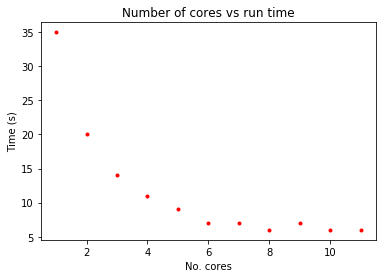

In [31]:
plt.figure()
plt.title("Number of cores vs run time")
plt.xlabel('No. cores')
plt.ylabel('Time (s)')

plt.plot(cores, times, 'r.')
